In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from joblib import dump

In [47]:
data_arr = np.load("../data/data_unfiltered.npy")
run_arr = np.load("../data/runs_unfiltered.npy")

# Using a reference run
train_data = data_arr[run_arr == 379456]
train_data

array([[1006.,  830.,  253., ...,    0.,    0.,    0.],
       [ 788.,  653.,  221., ...,    0.,    0.,    0.],
       [ 966.,  775.,  295., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [48]:
class Preprocessing(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        min_val = np.min(X, axis=0, keepdims=True)
        max_val = np.max(X, axis=0, keepdims=True)
        return np.where((max_val - min_val) != 0, (X - min_val) / (max_val - min_val + 1e-8), 0)

In [ ]:
class MSELoss(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        min_val = np.min(X, axis=0, keepdims=True)
        max_val = np.max(X, axis=0, keepdims=True)
        return np.where((max_val - min_val) != 0, (X - min_val) / (max_val - min_val + 1e-8), 0)

In [72]:
class NMFRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, **kwargs):
        self.nmf = NMF(**kwargs)

    def fit(self, X, y=None):
        self.nmf.fit(X)
        self.H = self.nmf.components_
        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        W = self.nmf.transform(X)
        rec = np.dot(W, self.H)
        mse = np.mean((X - rec)**2, axis=1)
        return rec, mse
    
    def score(self, X, y, sample_weight=None):
        preds, _ = self.predict(X)
        return np.mean((y - preds)**2, axis=1)


In [74]:
optimal_n_components = 2
train_data_norm = Preprocessing().transform(train_data)
benchmark = np.linalg.norm(train_data_norm, ord="fro") * 0.0001

while True:
    bst = Pipeline([
        ('scaler', Preprocessing()),
        ('nmf_model', NMFRegressor(n_components=optimal_n_components, init="random", random_state=42, max_iter=2900))
    ])
    bst.fit(train_data)
    
    mse = bst.score(train_data_norm, train_data_norm)
    avg_mse = np.mean(mse)

    if avg_mse < benchmark:
        break
    
    optimal_n_components += 1

print("optimal_n_components:", optimal_n_components)

optimal_n_components: 5


In [75]:
bst = Pipeline([
    ('scaler', Preprocessing()),
    ('nmf_model', NMFRegressor(n_components=optimal_n_components, init="random", random_state=42, max_iter=2900))
])
bst.fit(train_data)

Pipeline(steps=[('scaler', Preprocessing()), ('nmf_model', NMFRegressor())])

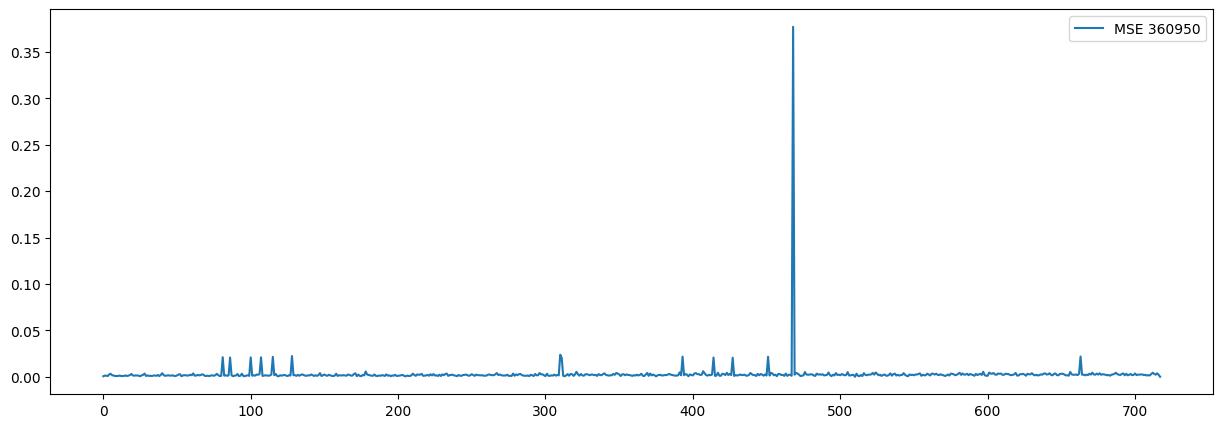

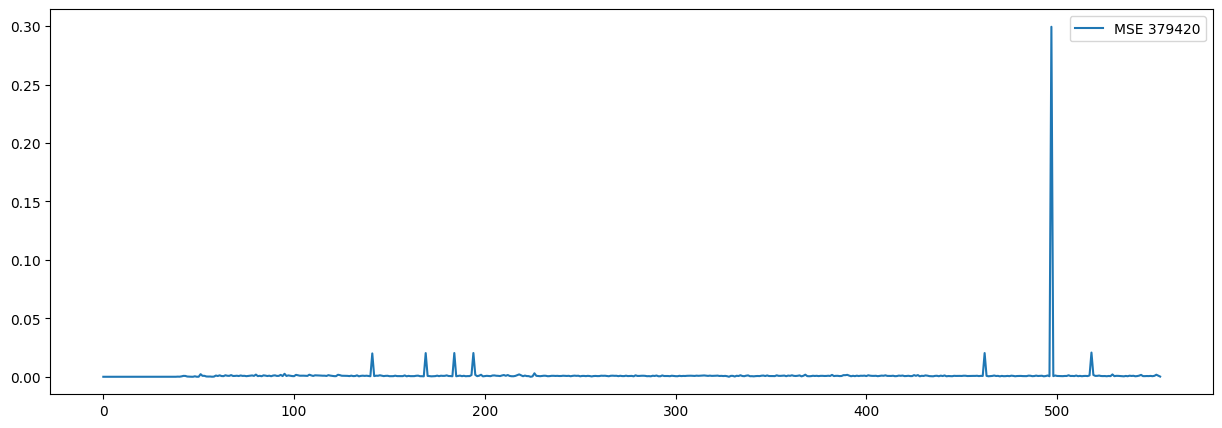

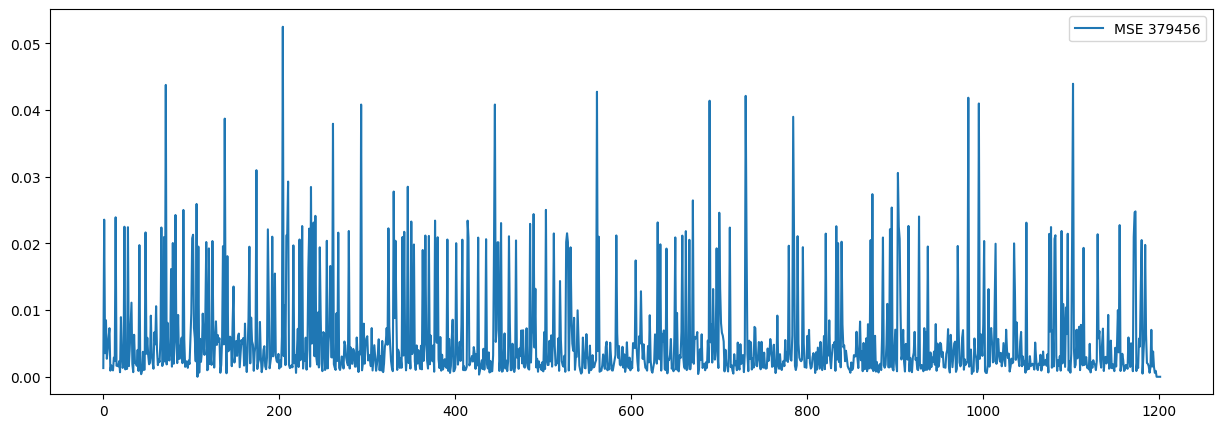

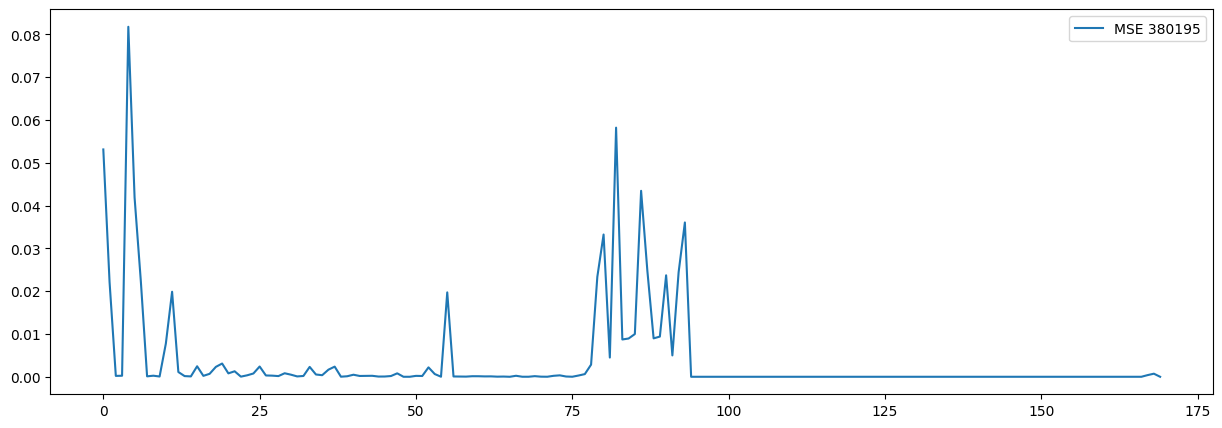

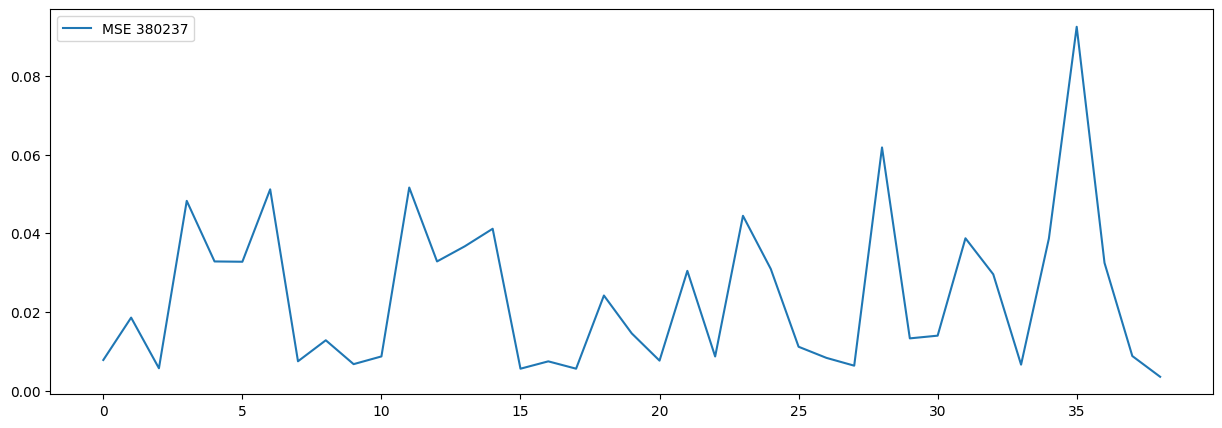

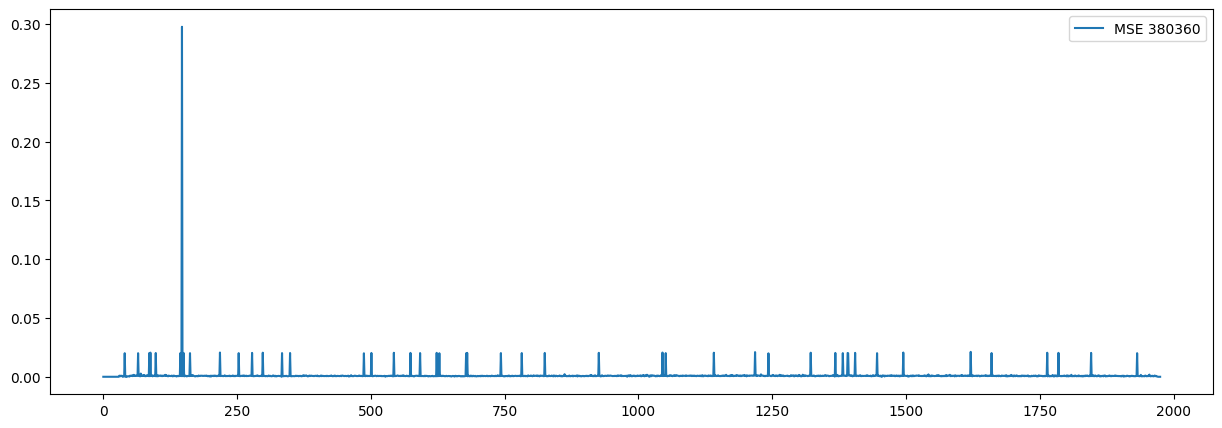

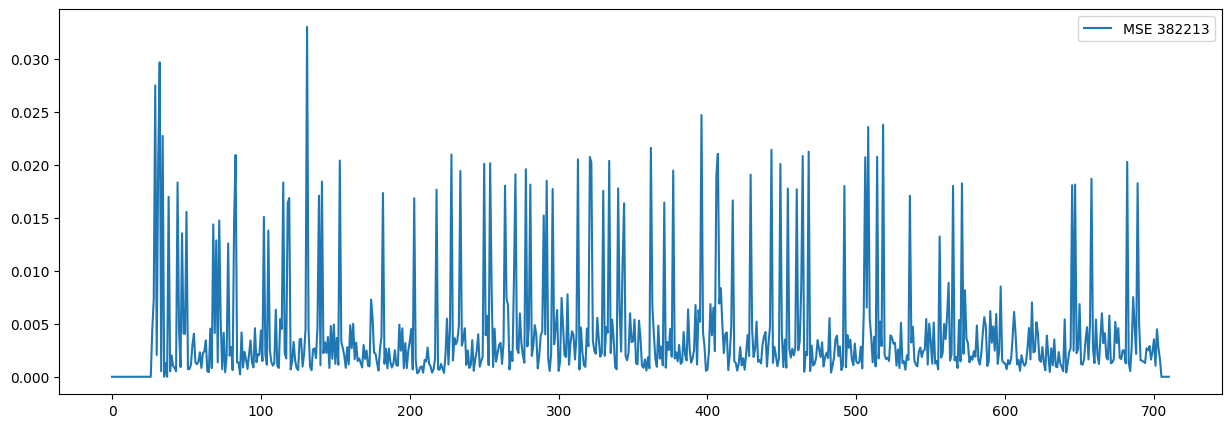

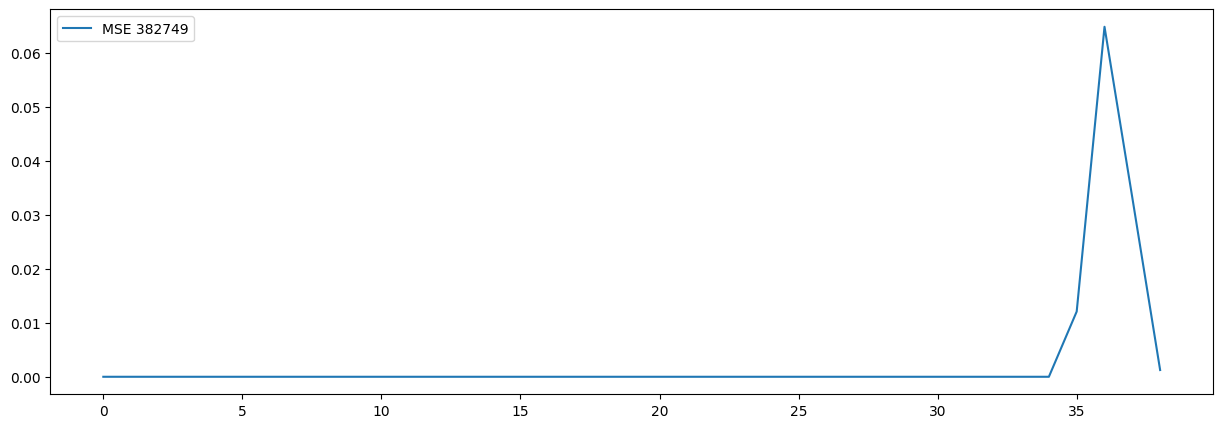

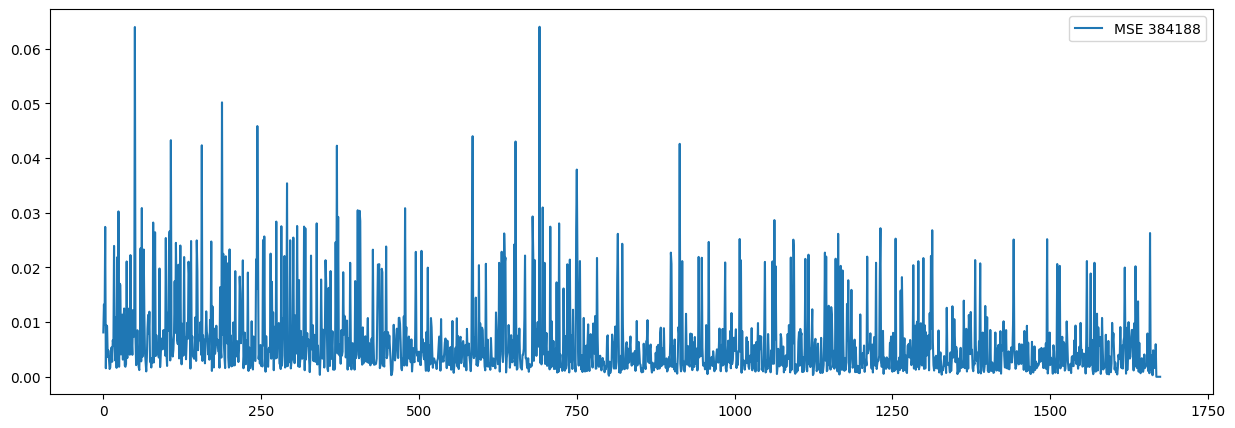

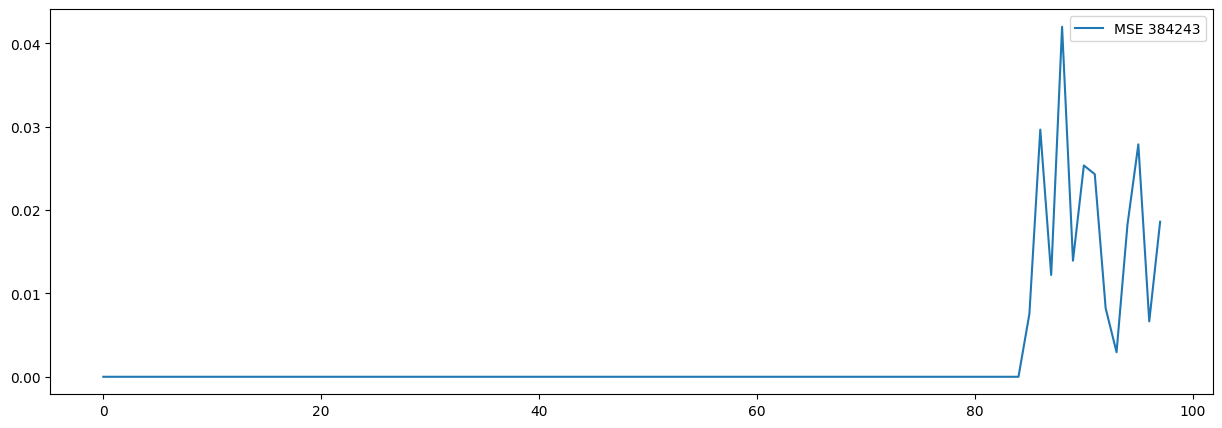

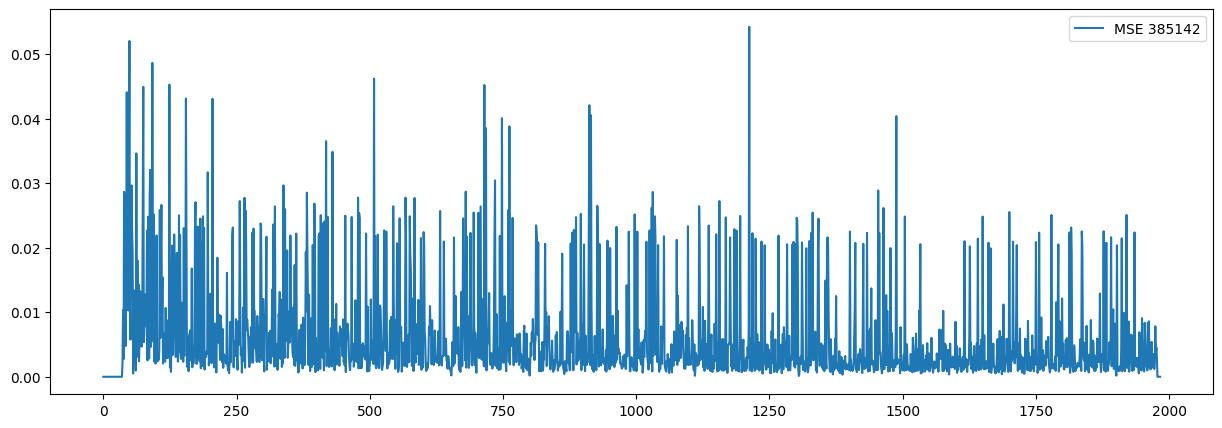

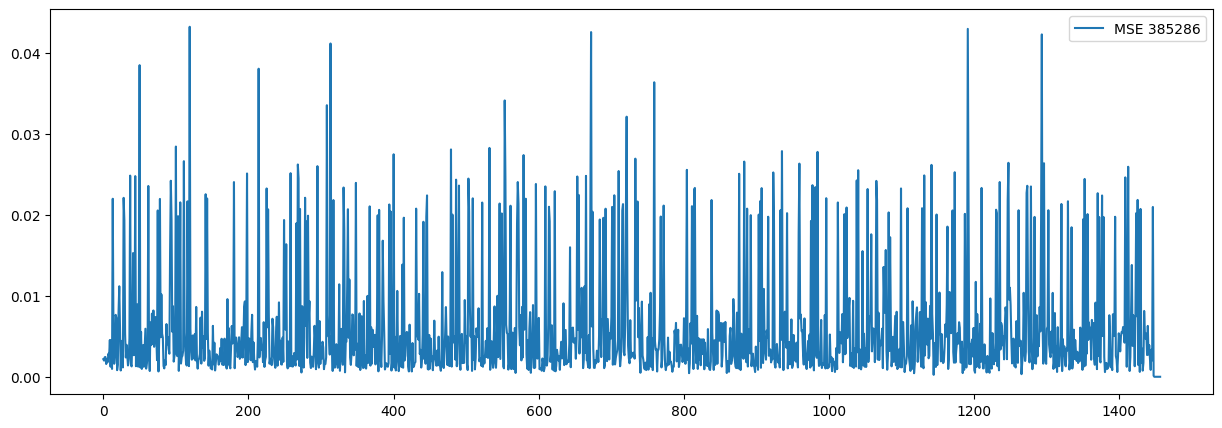

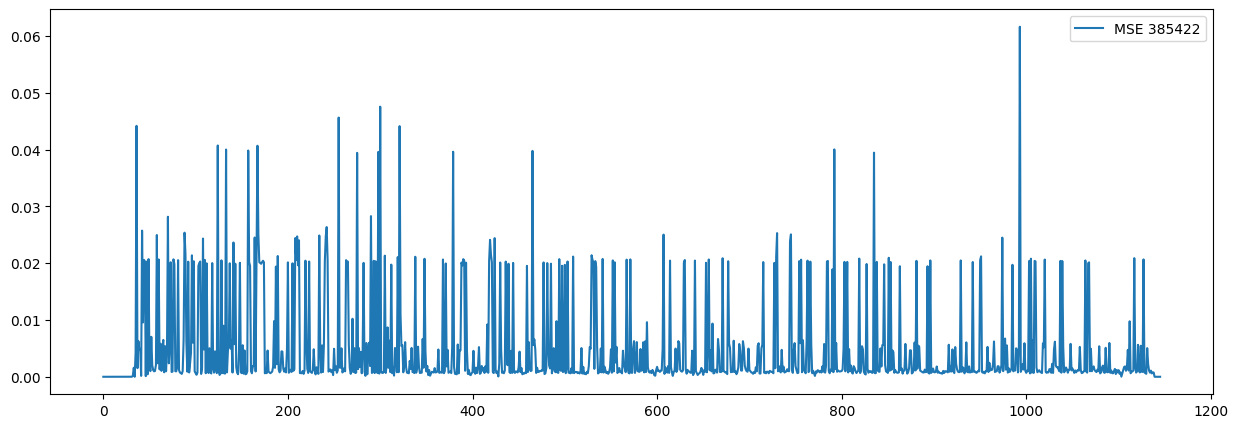

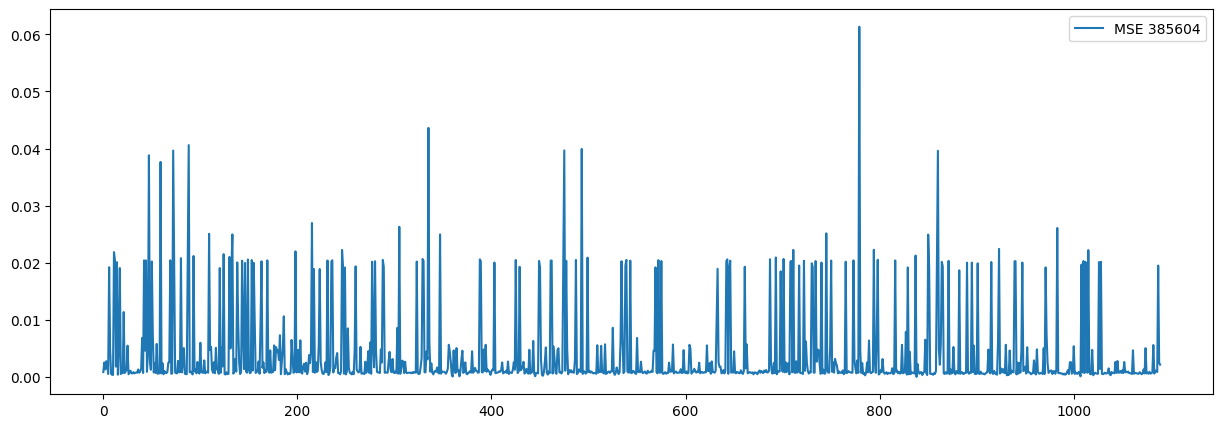

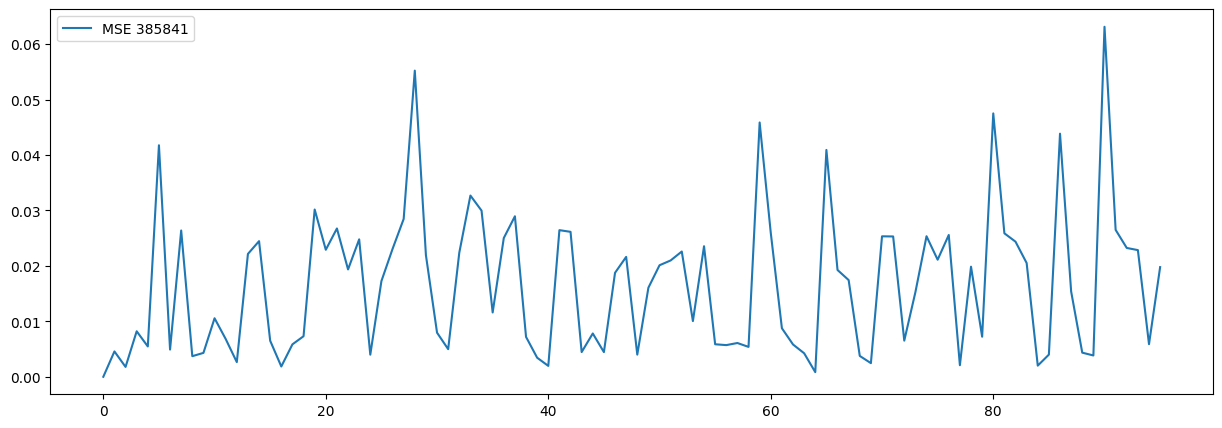

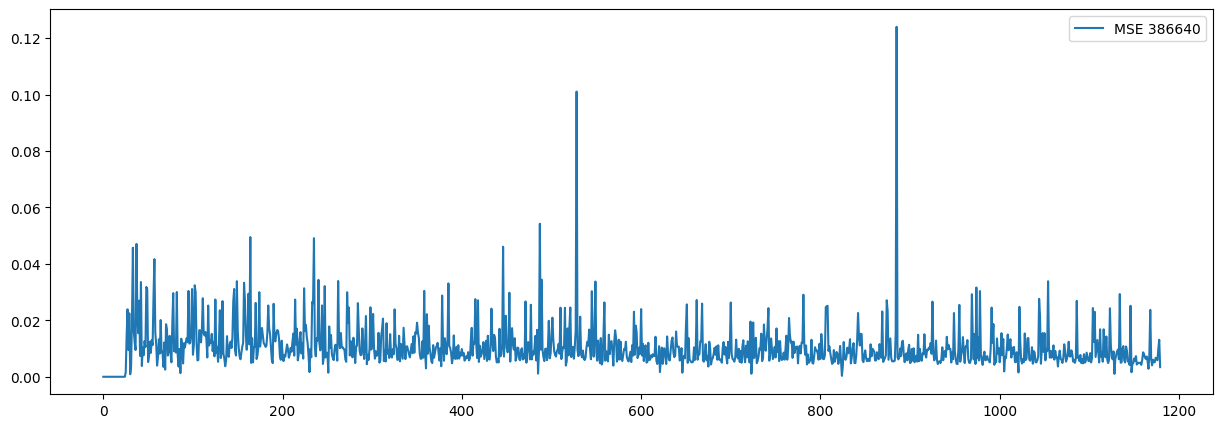

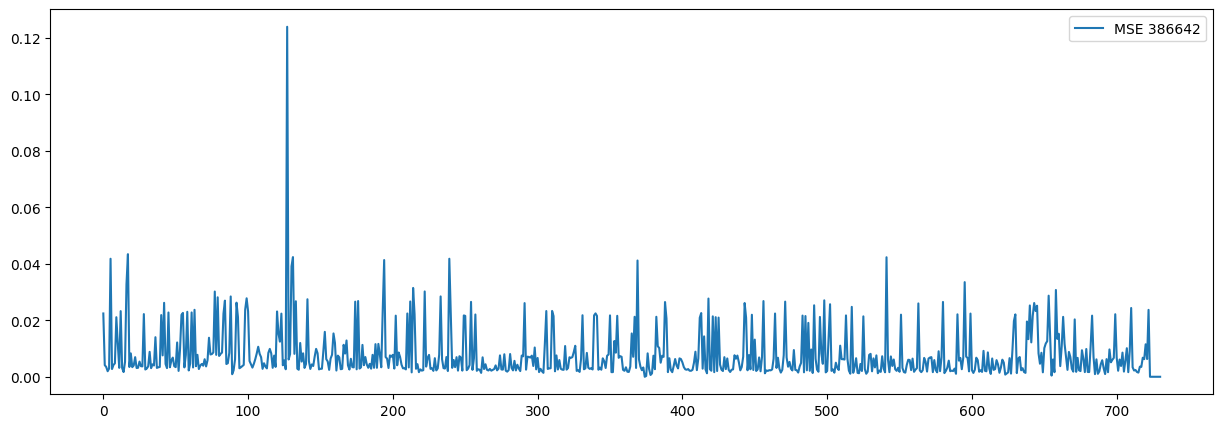

In [ ]:
for run_number in np.unique(run_arr):
    test_data = data_arr[run_arr == run_number]
    _, mse = bst.predict(test_data)

    plt.figure(figsize=(15, 5))
    plt.plot(range(mse.shape[0]), mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()

In [78]:
os.makedirs("../models/scikit_custom_regressor", exist_ok=True)
dump(bst, '../models/scikit_custom_regressor/model.joblib')

['../models/scikit_custom_regressor/model.joblib']